# Mini Proyecto 1

## Aprendizaje Automático Intermedio e Ingeniería de Características

### Febrero 2021

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Carga de datos y comprensión de las variables

In [1]:
data_sheet = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_excel(data_sheet,
                  header=1,
                skiprows=0,
                  index_col=0)

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [ ]:
df.head()

## Descripción de las variables de entrada

Esta es la descripción extraída de la web de la que se descargan los datos

- This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
- This study reviewed the literature and used the following 23 variables as explanatory variables:
    - X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
    - X2: Gender (1 = male; 2 = female).
    - X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
    - X4: Marital status (1 = married; 2 = single; 3 = others).
    - X5: Age (year).
    - X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -2=no consumption, -1=pay duly, 0=the use of revolving credit, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above
    - X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
    - X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



In [ ]:
# imprimir un registro para ver en detalle cada campo
df.loc[1568]

## Limpieza de variables

Algunas de las variables categóricas presentan valores que no aparecen en la descripción

### Education y Marriage

In [ ]:
columns_cat = ['EDUCATION','MARRIAGE']
for cc in columns_cat:
    print(cc)
    print(df[cc].value_counts())
    print("")

Vemos que aparecen valores que no están en la descripción, vamos a *limpiar* estas variables agrupando del siguiente modo:
- `EDUCATION`: pasar los valores $\{0, 5, 6\}$ a $4$ (`others`)
- `MARRIAGE`: pasar el valor $0$ a $3$ (`others`)

In [ ]:
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].apply(lambda x: 4 if x==0 else x)
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].apply(lambda x: 4 if x>=4 else x)
df.loc[:,'MARRIAGE'] = df.loc[:,'MARRIAGE'].apply(lambda x: 3 if x==0 else x)
for cc in columns_cat:
    print(cc)
    print(df[cc].value_counts())
    print("")

### Sacar discretas de PAY_0 a PAY_6 (3%)

Las variables `PAY_0` a `PAY_6` tienen una interpretación mixta entre categórica y numérica. Los valores $\{-2, -1 ,0\}$ pueden considerarse categóricos, mientras que los valores positivos pueden considerarse numéricos.

Vamos a codificarlas de modo categórico con las siguientes categorías:
- `PAY_X` $=-2$: no consumption
- `PAY_X` $=-1$: pay duly  
- `PAY_X` $=0$:  use of revolving credit
- `PAY_X` $ >0$: payment delay

Básicamente tenéis que escribir código que:
 - transforme todos los valores positivos en un solo valor, por ejemplo $1$
 - añanda columnas `PAY_X_dis` al dataframe con esos valores discretos

In [ ]:
#############
# YOUR CODE #
#############
for i in df.columns[5:11]:
    df[i+'_dis'] = df[i].apply(lambda x: 0 if x in [-2,-1,0] else x)
    df[i] = df[i].apply(lambda x: 1 if x>0 else x)
#######
# END #
#######    

In [ ]:
df.head()

## Partición en entrenamiento y test (2%)

Divida los datos aleatoriamente en dos dataframes con la siguiente distribución de tamaños:
- `train_df`: Entrenamiento 20K
- `test_df`: Test 10K

In [ ]:
df.shape

In [ ]:
#############
# YOUR CODE #
#############
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=10000, random_state=42)
#######
# END #
####### 

In [ ]:
print("Train {0:d} ejemplos".format(len(train_df)))
print("Test {0:d} ejemplos".format(len(test_df)))

## Clasificación trivial (5%)

El primer paso es establecer el clasificador *baseline* contra el que vamos a comparar los resultados de los modelos que vayamos entrenando a lo largo del *notebook*.

Este resultado depende de si las clases están o no desbalanceadas. **Analizad el desbalanceo en el dataframe** `train_df` y elegid el resultado del clasificador *baseline*.

In [ ]:
#############
# YOUR CODE #
#############
max_prob_category = train_df['default payment next month'].value_counts(normalize=True, ascending=False)
print('Si Clasificador Baseline consiste en predecir que nunca habrá impago (0), Acertaré el %s de las veces'%(train_df['default payment next month'].value_counts(normalize=True)[0]*100))
global_results ={} # to store the results of the different models for comparison purposes
global_results['Baseline'] = train_df['default payment next month'].value_counts(normalize=True)[0]
#######
# END #
####### 

# 1. Regresión Logística con variables numéricas

El primer modelo que vamos a construir es un clasificador basado en [**regresión logística**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) sólo empleando como entradas las variables numéricas. 

## 1.1 Identificar variables numéricas (5%)
Construid una lista de python llamada `num_var` con las variables numéricas (las que no son categóricas)

In [ ]:
df.head()

In [ ]:
#############
# YOUR CODE #
#############
import re
r = re.compile("^PAY_[0-9]*$|^SEX$|^EDUCATION$|^MARRIAGE$|^defa*") # REGEX EXPRESSION
num_var = [col for col in df.columns if  col not in list(filter(r.match, df.columns))]
#######
# END #
####### 
print("Variables numéricas")
print(num_var)

## 1.2 Construir el modelo de regresión logística solo con las variables numéricas (10%)

- Usad `Pipeline` y `GridSearchCV` para introducir un escalado como preprocesado, si lo veis oportuno.
- Usad los siguientes nombres para los numpy arrays con los que llaméis los métodos (`fit`, `sore`, `predict`,etc) del regresor logístico:
    - `X_train`
    - `Y_train`
    - `X_test`
    - `Y_test`
- Comparad el resultado del modelo en el conjunto de test con la solución trivial


In [ ]:
#############
# YOUR CODE #
#############
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Training set observations
X_train = train_df[num_var]
# Training set targets
Y_train = train_df['default payment next month'].values
# Test set observations
X_test = test_df[num_var]
# Test set targets
Y_test = test_df['default payment next month'].values

# Set the Pipeline
pipe = Pipeline(steps=[('scaler', MinMaxScaler()), ('logistic',LogisticRegression())])
# Params
params_pipe = {'logistic__solver':['lbfgs'],
               'logistic__max_iter':[10000],
               'logistic__penalty' : ['l2'],
               'scaler':[MinMaxScaler(), StandardScaler(),'passthrough']}
# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(X_train, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(X_train, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(X_test,Y_test)))
# Storing the result
global_results['LogisticRegression'] = grid_pipe.score(X_test,Y_test)
#######
# END #
#######

## 1.3 Pintar pesos y dar interpretación (5%)

Imprimid los pesos del regresor logístico con el nombre de la variable correspondiente

- Peso w0: XXX.XX
- peso Variable1: YYY.YY
- ...
- peso VariableM: ZZZZ.ZZZZ

y comentad la relevancia de cada variable en la clasificación. Puede ser de ayuda imprimir los pesos ordenados por valor absoluto.

In [ ]:
#############
# YOUR CODE #
#############
scaler = grid_pipe.best_estimator_.named_steps['scaler']
logreg = grid_pipe.best_estimator_.named_steps['logistic']
weights = []
weights_abs = []
for var,coef in zip(num_var,logreg.coef_[0]):
    weights_abs.append((var,abs(coef)))
    weights.append((var,coef))
    weights_abs.sort(key=lambda tup: tup[1],reverse=True)

print('La variable que más peso tiene es la que describe cuantos meses se han impagado en el mes más reciente',weights_abs[0])
weights_abs

#######
# END #
#######

## 1.4 Curva ROC (10%)

Dibujar la [curva ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) del clasificador anterior y calcular el [área bajo la curva](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). Usad el conjunto de test para este apartado.

In [2]:
#############
# YOUR CODE #
#############
from sklearn import metrics
import matplotlib.pyplot as plt

def roc(x_test, y_test, classifier):
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    y_pred_prob = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for Default Credit Card Clients')
    plt.xlabel('False Positive Rate (1 - Specificity)\n+++Specificity---')
    plt.ylabel('True Positive Rate (Sensitivity)\n---Sensitivity+++')
    plt.grid(True)
    print('AUC is the percentage of the ROC plot that is underneath the curve:',metrics.roc_auc_score(y_test, y_pred_prob))
roc(X_test, Y_test, grid_pipe)
#######
# END #
#######

ModuleNotFoundError: No module named 'sklearn'

## 1.5 Transformación logarítmica de las variables numéricas y comparar (5%)

Para controlar el impacto de los rangos de las variables numéricas vamos a emplear una transformación logarítmica. Como hay valores que pueden ser negativos, y el logaritmo sólo está definido para valores positivos, vamos a extender la transformación de modo que:
$$
y(x) = \mbox{signo}(x) \log_{10}(x)
$$

Escriba código que:
- Aplique la siguiente función para hacer la transformación de los numpy arrays `X_train` y `X_test` en `LXtrain` y `LXtest`.
- Entrene un modelo de regresión logística con las variables transformadas
- Compare el acierto de este modelo con el baseline y con el modelo anterior
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 

Discuta las diferencias entre este modelo y el anterior

In [39]:
import numpy as np
def log_transform(x):
    negativos = x <0
    ceros = x == 0
    ax = np.absolute(x)
    ax[ceros] = 1
    Lx = np.log10(ax)
    Lx[negativos] = -Lx[negativos]
    Lx[ceros] = 0
    return Lx

{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': StandardScaler()} 
 ____________________________________________________________________________________________________
Score with the training data 0.8153
Score with the test data 0.8147 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.8164, 'LOG_LogisticRegression': 0.8147} 
 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7673280173910637
_____________________________________________________________________________________________________ 
La variable que más peso tiene es la que describe cuantos meses se han impagado en el mes más reciente ('PAY_0_dis', 0.5673520009016434)
La cantidad de crédito solicitado se vuelve más relevante con la transformación logarítmica  ('LI

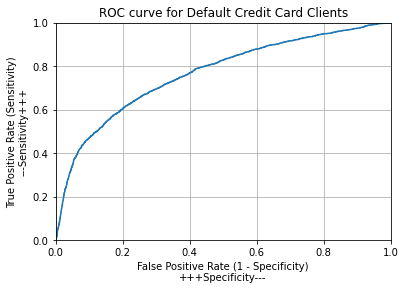

In [40]:
#############
# YOUR CODE #
#############

# Log Transformation
LXtrain = X_train.apply(log_transform)
LXtest = X_test.apply(log_transform)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(LXtrain, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(LXtest,Y_test)),'\n','_'*100)

# Storing the result
global_results['LOG_LogisticRegression'] = grid_pipe.score(LXtest,Y_test)
print(global_results,'\n','_'*100)

# ROC AUC
roc(LXtest, Y_test, grid_pipe)

# Weights
scaler = grid_pipe.best_estimator_.named_steps['scaler']
logreg = grid_pipe.best_estimator_.named_steps['logistic']
weights = []
weights_abs = []
for var,coef in zip(num_var,logreg.coef_[0]):
    weights_abs.append((var,abs(coef)))
    weights.append((var,coef))
    weights_abs.sort(key=lambda tup: tup[1],reverse=True)

weights_abs

print('_'*101,'\n''La variable que más peso tiene es la que describe cuantos meses se han impagado en el mes más reciente',weights_abs[0])
print('La cantidad de crédito solicitado se vuelve más relevante con la transformación logarítmica ',weights_abs[1])
#######
# END #
#######




## 1.6 Combinaciones de variables numéricas, extensión polinómica y de ratios (5%)

Para completar el análisis de las variables numéricas vamos a extender las mismas con combinaciones de variables. 

Escriba código que:
- Extienda las variables en los arrays `LXtrain` y `LXtest` a combinaciones de grado 2, y con variables sin repetir (es decir, con el argumento `interaction_only=True`).
- Entrena un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 

Discuta las diferencias entre este modelo y los anteriores

{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': MinMaxScaler()} 
 ____________________________________________________________________________________________________
Score with the training data 0.8213
Score with the test data 0.8195 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.8164, 'LOG_LogisticRegression': 0.8147, 'POL_2_LOG_LogisticRegression': 0.8195} 
 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7679377879292868
_____________________________________________________________________________________________________ 
La 1º variable que más peso tiene es: ('PAY_0_dis PAY_2_dis', 3.403611443457014)
La 2º variable que más peso tiene es: ('BILL_AMT1 PAY_0_dis', 1.9043842149276753)


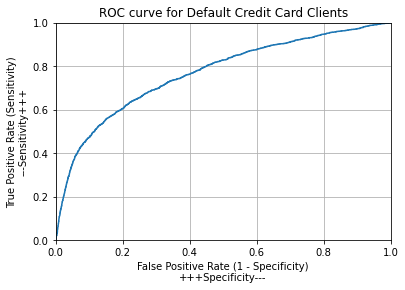

In [41]:
#############
# YOUR CODE #
#############
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True, 
                          degree=2,
                         include_bias=False)
LXtrain_e = poly.fit_transform(LXtrain)
LXtest_e = poly.transform(LXtest)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain_e, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(LXtrain_e, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(LXtest_e,Y_test)),'\n','_'*100)

# Storing the result
global_results['POL_2_LOG_LogisticRegression'] = grid_pipe.score(LXtest_e,Y_test)
print(global_results,'\n','_'*100)

# ROC AUC
roc(LXtest_e, Y_test, grid_pipe)

# Weights
scaler = grid_pipe.best_estimator_.named_steps['scaler']
logreg = grid_pipe.best_estimator_.named_steps['logistic']
weights = []
weights_abs = []
for var,coef in zip(poly.get_feature_names(num_var),logreg.coef_[0]):
    weights_abs.append((var,abs(coef)))
    weights.append((var,coef))
    weights_abs.sort(key=lambda tup: tup[1],reverse=True)

weights_abs

print('_'*101,'\n''La 1º variable que más peso tiene es:',weights_abs[0])
print('La 2º variable que más peso tiene es:',weights_abs[1])
#######
# END #
#######

# 2. Añadir variables categóricas con dummy encodings 

En la siguiente sección vamos a enriquecer los modelos añadiendo variables categóricas



## 2.1 Discretizar edad en 5 bins (10%)

Vamos a comenzar discretizando la edad en 5 *bins*. Escriba código que
- Discretice la variable `AGE` en 5 *bins* con aproximadamente el mismo número de clientes en cada bin, incluyendo una columna llamada 'AGE_bins' en los dataframes `train_df` y `test_df` con los números de *bin* correspondiente
- Obtenga numpy arrays `X_train_cat_dummy` y `X_test_cat_dummy` con la codificación *dummy* de las variable `AGE_bins`
- Extienda las observaciones añadiendo estos arrays a `LXtrain` y `LXtest` (no incluyáis las extensiones polinómicas). Eliminando la columna correspondiente a la variable `AGE`original.
- Entrene un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': 'passthrough'} 
 ____________________________________________________________________________________________________
Score with the training data 0.8153
Score with the test data 0.8140 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.8164, 'LOG_LogisticRegression': 0.8147, 'POL_2_LOG_LogisticRegression': 0.8195, 'AGE_dummies_LOG_LogisticRegression': 0.814} 
 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7666141075179865
_____________________________________________________________________________________________________ 
La 1º variable que más peso tiene es: ('PAY_0_dis', 5.069237680775955)
La 2º variable que más peso tiene es:  ('PAY_6_dis', 1.151182254751394)


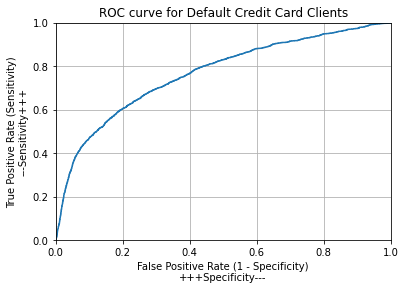

In [42]:
#############
# YOUR CODE #
#############
from sklearn.preprocessing import OneHotEncoder

# BINS
bins = train_df['AGE'].quantile([.2,.4,.6,.8])
train_df['AGE_bins'] = np.digitize(train_df['AGE'].values, bins)
test_df['AGE_bins'] = np.digitize(test_df['AGE'].values, bins)

# Dummy Coding
dummy = OneHotEncoder(sparse = False,drop='first')
X_train_cat_dummy = dummy.fit_transform(train_df[['AGE_bins']])
X_test_cat_dummy = dummy.transform(test_df[['AGE_bins']])
for i in dummy.categories_[0][1:]:
    LXtrain['AGE_bin_'+str(i)] = X_train_cat_dummy[:,i-1]
    LXtest['AGE_bin_'+str(i)] = X_test_cat_dummy[:,i-1]

# FINAL X_Train X_test
LXtrain.drop(columns=['AGE'],inplace=True)
LXtest.drop(columns=['AGE'],inplace=True)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(LXtrain, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(LXtest,Y_test)),'\n','_'*100)

# Storing the result
global_results['AGE_dummies_LOG_LogisticRegression'] = grid_pipe.score(LXtest,Y_test)
print(global_results,'\n','_'*100)

# ROC AUC
roc(LXtest, Y_test, grid_pipe)

# Weights
scaler = grid_pipe.best_estimator_.named_steps['scaler']
logreg = grid_pipe.best_estimator_.named_steps['logistic']
weights = []
weights_abs = []
for var,coef in zip(LXtrain.columns,logreg.coef_[0]):
    weights_abs.append((var,abs(coef)))
    weights.append((var,coef))
    weights_abs.sort(key=lambda tup: tup[1],reverse=True)

weights_abs

print('_'*101,'\n''La 1º variable que más peso tiene es:',weights_abs[0])
print('La 2º variable que más peso tiene es: ',weights_abs[1])
#######
# END #
#######

## 2.2 Añadir más variables categóricas: variables PAY_0 a PAY_6 e info sociodemográfica (10%)

A continuación  vamos a añadir al modelo las variables que describen el histórico de los usos del crédito y de los retrasos en el pago y las variables `SEX`,`EDUCATION`, `MARRIAGE` y `AGE_bins` codificadas con *dummy encoding*.
. Escriba código que: 
- Obtenga numpy arrays `X_train_cat_dummy` y `X_test_cat_dummy` con la codificación *dummy* de las variables `SEX`,`EDUCATION`,`MARRIAGE`, `PAY_0_dis`, `PAY_2_dis`, `PAY_3_dis`, `PAY_4_dis`, `PAY_5_dis` y `PAY_6_dis`
- Extienda las observaciones añadiendo estos arrays a `LXtrain` y `LXtest` (no incluyáis las extensiones polinómicas). Eliminando la columna correspondiente a la variable `AGE`original.
- Entrene un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 


{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': 'passthrough'} 
 ____________________________________________________________________________________________________
Score with the training data 0.8201
Score with the test data 0.8194 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.8164, 'LOG_LogisticRegression': 0.8147, 'POL_2_LOG_LogisticRegression': 0.8195, 'AGE_dummies_LOG_LogisticRegression': 0.814, 'More_CAT_dummies_LOG_LogisticRegression': 0.8194} 
 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7696451395742603
_____________________________________________________________________________________________________ 
La 1º variable que más peso tiene es: ('PAY_0_dis', 3.4118392341801753)
La 2º variable que más peso t

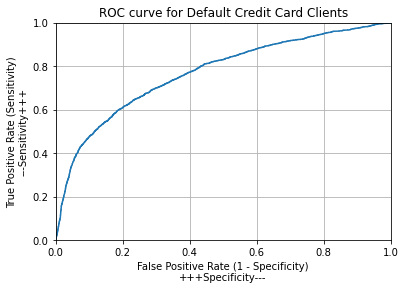

In [43]:
#############
# YOUR CODE #
#############
# Dummy Coding

def create_dummy(var,train,test,x_train,x_test):
    dummy = OneHotEncoder(sparse = False,drop='first')
    X_train_cat_dummy = dummy.fit_transform(train[[var]])
    X_test_cat_dummy = dummy.transform(test[[var]])
    for i in range(len(dummy.categories_[0][1:])):
        x_train[var+str(i)] = X_train_cat_dummy[:,i]
        x_test[var+str(i)] = X_test_cat_dummy[:,i]

cat_vars = ['SEX','EDUCATION','MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in cat_vars:
    create_dummy(col,train_df,test_df,LXtrain,LXtest)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(LXtrain, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(LXtest,Y_test)),'\n','_'*100)

# Storing the result
global_results['More_CAT_dummies_LOG_LogisticRegression'] = grid_pipe.score(LXtest,Y_test)
print(global_results,'\n','_'*100)

# ROC AUC
roc(LXtest, Y_test, grid_pipe)

# Weights
scaler = grid_pipe.best_estimator_.named_steps['scaler']
logreg = grid_pipe.best_estimator_.named_steps['logistic']
weights = []
weights_abs = []
for var,coef in zip(LXtrain.columns,logreg.coef_[0]):
    weights_abs.append((var,abs(coef)))
    weights.append((var,coef))
    weights_abs.sort(key=lambda tup: tup[1],reverse=True)

weights_abs

print('_'*101,'\n''La 1º variable que más peso tiene es:',weights_abs[0])
print('La 2º variable que más peso tiene es: ',weights_abs[1])
#######
# END #
#######

## 2.4 OPCIONAL: métodos no lineales (10%, extra)

**Este apartado es opcional: su nota se suma a la nota del proyecto, pero no es necesario para conseguir la máxima calificación.**

Podemos cambiar la tecnología de clasificación por si acaso el modelo que mejor se ajuste a nuestros datos fuese no lineal. 

Escribid código que evalúe modelos construidos con $k$ vecinos más próximos. Emplead como juegos de características los del apartado anterior. Explorad el rango de vecinos entre 1 y 101 (no hace falta que probéis todos los valores, que la base de datos no es pequeña)

Alternativamente podéis emplear [*Random Forest*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) explorando estos rangos de parámetros:
- `n_estimators` 
- `max_leaf_nodes` o `max_depth`

{'rf__max_depth': 35, 'rf__n_estimators': 85, 'scaler': 'passthrough'} 
 ____________________________________________________________________________________________________
Score with the training data 0.9978
Score with the test data 0.8127 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.8164, 'LOG_LogisticRegression': 0.8147, 'POL_2_LOG_LogisticRegression': 0.8195, 'AGE_dummies_LOG_LogisticRegression': 0.814, 'More_CAT_dummies_LOG_LogisticRegression': 0.8194, 'More_CAT_dummies_LOG_RandomForest': 0.8127} 
 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7539965997759759


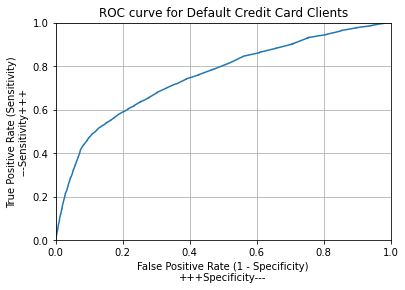

In [44]:
#############
# YOUR CODE #
#############
from sklearn.ensemble import RandomForestClassifier

# Set the Pipeline
pipe = Pipeline(steps=[('scaler', MinMaxScaler()), ('rf',RandomForestClassifier())])
# Params
params_pipe = {'rf__n_estimators':[85],#[75,79,81,85],
               'rf__max_depth':[35],#[30,35,40],
               'scaler':[MinMaxScaler(), StandardScaler(),'passthrough']}
# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(LXtrain, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(LXtest,Y_test)),'\n','_'*100)

# Storing the result
global_results['More_CAT_dummies_LOG_RandomForest'] = grid_pipe.score(LXtest,Y_test)
print(global_results,'\n','_'*100)

# ROC AUC
roc(LXtest, Y_test, grid_pipe)

#######
# END #
#######

# 3. Estudio de grupos demográficos

En la última sección vamos a intentar mejorar la interpretabilidad de los modelos mediante la creción de unas variables que segmenten los clientes atendiendo a criterios sociodemográficos.

En primer lugar vamos a definir los segmentos de clientes definidos por las variables `SEX`,`EDUCATION`,`MARRIAGE`,`AGE_bins`. Primero vamos a agrupar estas variables en una única variable categórica `GRUPO` que tomará distintos valores enteros en función de las combinaciones de estas variables.

El siguiente código es una manera de conseguir esto. Básicamente cada grupo se codifica con un entero que resulta de sumar los siquientes valores:

$$
\mbox{GRUPO}(x) = 1000 \times x[\mbox{'SEX'}] + 100 \times x[\mbox{'EDUCATION'}] + 10 \times x[\mbox{'MARRIAGE'}] + x[\mbox{'AGE_bins'}] 
$$



In [45]:
columns_cat = ['SEX','EDUCATION','MARRIAGE','AGE_bins']
mascara = np.array([1000, 100, 10, 1])
train_df.loc[:,'GRUPO'] = (train_df.loc[:,columns_cat].values).dot(mascara)
test_df.loc[:,'GRUPO']= (test_df.loc[:,columns_cat].values).dot(mascara)


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## 3.1 Grupos con dummy encoding y variables continuas (10%)

La primera aproximación consiste en codificar *dummy encoding* la variable grupo. En este caso hay que pasarle al objeto `OneHotEncoder` un listado con las categorías que hay en cada característica porque puede que algún grupo minoritario aparezca en el conjunto de test pero no en el de entrenamiento, por lo que el codificador no va a ser capaz de aprender todos los valores de esa característica solo mirando el conjunto de entrenamiento.

El siguiente código se encarga de hacer esto mismo. La salida de este código son dos variables a tener en cuenta:
- `lista_grupo`: lista de python con todos los valores que puede tomar la variable `GRUPO`
- `dict_grupo`: diccionario de python donde cada valor que puede tomar la variable `GRUPO` se empareja con una cadena de caracteres que describe el segmento de clientes que codifica este valor



In [46]:
lista_values = []
for cc,mm in zip(['SEX','EDUCATION','MARRIAGE','AGE_bins'], mascara):
    lista_values.append([(jj)*mm for jj in np.unique(train_df[cc].values)])
print(lista_values)
import itertools
lista_grupo = []
dict_grupo = {}
for element in itertools.product(*lista_values):
    code_grupo = np.sum(np.asarray(element))
    lista_grupo.append(code_grupo)
    dict_grupo[code_grupo] = "SEX_{0:d}_EDU_{1:d}_MAR_{2:d}_AGE_{3:d}".format(int(element[0]/1000), 
                                                                              int(element[1]/100), 
                                                                              int(element[2]/10), 
                                                                              int(element[3]))   

print("")
print("lista_grupo: ",lista_grupo)
print("")
print("dict_grupo",dict_grupo)

[[1000, 2000], [100, 200, 300, 400], [10, 20, 30], [0, 1, 2, 3, 4]]

lista_grupo:  [1110, 1111, 1112, 1113, 1114, 1120, 1121, 1122, 1123, 1124, 1130, 1131, 1132, 1133, 1134, 1210, 1211, 1212, 1213, 1214, 1220, 1221, 1222, 1223, 1224, 1230, 1231, 1232, 1233, 1234, 1310, 1311, 1312, 1313, 1314, 1320, 1321, 1322, 1323, 1324, 1330, 1331, 1332, 1333, 1334, 1410, 1411, 1412, 1413, 1414, 1420, 1421, 1422, 1423, 1424, 1430, 1431, 1432, 1433, 1434, 2110, 2111, 2112, 2113, 2114, 2120, 2121, 2122, 2123, 2124, 2130, 2131, 2132, 2133, 2134, 2210, 2211, 2212, 2213, 2214, 2220, 2221, 2222, 2223, 2224, 2230, 2231, 2232, 2233, 2234, 2310, 2311, 2312, 2313, 2314, 2320, 2321, 2322, 2323, 2324, 2330, 2331, 2332, 2333, 2334, 2410, 2411, 2412, 2413, 2414, 2420, 2421, 2422, 2423, 2424, 2430, 2431, 2432, 2433, 2434]

dict_grupo {1110: 'SEX_1_EDU_1_MAR_1_AGE_0', 1111: 'SEX_1_EDU_1_MAR_1_AGE_1', 1112: 'SEX_1_EDU_1_MAR_1_AGE_2', 1113: 'SEX_1_EDU_1_MAR_1_AGE_3', 1114: 'SEX_1_EDU_1_MAR_1_AGE_4', 1120: 'SEX_1_EDU_1

Escriba código que construya el argumento que se le debe pasar a la clase `OneHotEncoder` como argumento `categories` si queremos codificar *dummy encoding* las variables `GRUPO`, `PAY_0_dis`, `PAY_2_dis`, `PAY_3_dis`, `PAY_4_dis`, `PAY_5_dis` y `PAY_6_dis`. Este argumento debe ser un array de listas, donde cada elemento del array principal es la lista con todos los valores que debe tomar la categoría:

`lista=[[lista_grupo],[lista_PAY_0_dis],...,[lista_PAY_6_dis]]`

In [ ]:
#############
# YOUR CODE #
#############


#######
# END #
#######

A continuación escribid código que:
- Obtenga numpy arrays `X_train_cat_dummy` y `X_test_cat_dummy` con la codificación *dummy* de las variables `GRUPO`, `PAY_0_dis`, `PAY_2_dis`, `PAY_3_dis`, `PAY_4_dis`, `PAY_5_dis` y `PAY_6_dis`
- Extienda las observaciones añadiendo estos arrays a `LXtrain` y `LXtest` (no incluyáis las extensiones polinómicas). Eliminando la columna correspondiente a la variable `AGE` original.
- Entrene un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 

In [ ]:
#############
# YOUR CODE #
#############

#######
# END #
#######





## 3.3 Bin counting de los grupos con variables continuas y regresión logística (20%)

Dado el gran número de grupos vamos a finalizar el *notebook* empleando conteos de *bins* para codificar esta variable

En primer lugar escribid código que represente en el eje de las x una entrada por cada grupo y en el eje de las y el número de clientes que hay en ese grupo.

¿Cuántos grupos tienen más de 100 clientes?

In [ ]:
#############
# YOUR CODE #
#############

#######
# END #
#######

In [ ]:
class bin_counter(object):
    def __init__(self, back_off_threshold = 0):
        self.back_off_threshold = back_off_threshold
        self.backed_off_categories = []
        pass
    def fit_transform(self, x, y):
        self.fit(x,y)
        return self.transform(x)
    def transform(self, x):
        N = len(x)
        output = np.empty((N, self.d))
        x_categories = np.unique(x)
        for cat in x_categories:
            if cat not in self.code_book:
                code = self.code_book['average']
            elif cat in self.backed_off_categories:
                code = self.code_book['back-off']
            else:
                code = self.code_book[cat]
            posi = np.where(x==cat)[0]
            output[posi,:] = code
        return output
    def fit(self, x, y):
        self.code_book = {}
        N = len(x)
        y_categories = np.unique(y)
        self.d = len(y_categories)
        x_categories = np.unique(x)
        num_x_categories = len(x_categories)
        y_ohe = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1,1))
        back_off_counts = np.zeros(self.d)
        num_back_off = 0
        for cat in x_categories:
            posi = np.where(x==cat)[0]
            if len(posi) >= self.back_off_threshold:
                code = np.mean(y_ohe[posi,:],0)
                self.code_book[cat] = code
            else:
                self.backed_off_categories.append(cat)
                back_off_counts += np.sum(y_ohe[posi,:],0)
                num_back_off += len(posi)
        if num_back_off > 0:
            self.code_book['back-off']  = back_off_counts / num_back_off
        self.code_book['average'] =  np.mean(y_ohe,0)

Para evaluar el efecto del *leakage* vamos a en primer lugar usar el conjunto de entrenamiento que hemos empleado hasta ahora para aprender los conteos de bin y el modelo de regresión logística. Complete la parte final de este código para entrenar el modelo y medir sus prestaciones

In [ ]:
bc_leakage = bin_counter(back_off_threshold=100)
train_grupo_bc = bc_leakage.fit_transform(train_df['GRUPO'].values, Y_train)
test_grupo_bc = bc_leakage.transform(test_df['GRUPO'].values)


"""
- Codifica dummy encoding las variables PAY_0_dis', 'PAY_2_dis',
       'PAY_3_dis', 'PAY_4_dis', 'PAY_5_dis', 'PAY_6_dis'
- genera X_train_e  apilando las columnas de LXtrain, X_train_cat_dummy y train_df_bc[:,1]
- genera X_test_e análogamente
- entrena el modelo de regresión logística con X_train_e
- evalúa el modelo (acierto en entrenamiento, acierto en test y area bajo la curva ROC)
"""
#############
# YOUR CODE #
#############

#######
# END #
#######

Ahora repetid el análisis de la celda anterior pero previamente dividiendo el conjunto de entrenamiento en dos mitades del mismo tamaño: 
- `train_bc_df` para aprender los conteos de bin y 
- `train_model_df` para entrenar el regresor logístico

Comparad las prestaciones en ambos casos y evaluar el impacto del *leakage*

In [ ]:
#############
# YOUR CODE #
#############

#######
# END #
#######

### ¿Cuál es el peso de la variable `GRUPO` codificada con conteo de bin en ambos casos?


In [ ]:
#############
# YOUR CODE #
#############


#######
# END #
#######

## OPCIONAL: interpretabilidad de los grupos demográficos (5%, extra)

**Este apartado es opcional: su nota se suma a la nota del proyecto, pero no es necesario para conseguir la máxima calificación.**

Ordenad los grupos de acuerdo a la probabilidad de default y verificar si hay muchas diferencias entre las primeras posiciones del *ranking*, las últimas, y los valores *bask-off* y *average*.

In [ ]:
#############
# YOUR CODE #
#############
        
#######
# END #
#######